In [171]:
import numpy as np
from matplotlib import pyplot as plt
import random as rand
import itertools
from sklearn import svm

In [172]:
class Perceptron:
    def __init__(self, input_dimension):
        self.input_dimension = input_dimension
        self.weights = np.random.random((input_dimension,))
        self.bias = np.random.random()
        
    def predict(self, data):
        activation = np.dot(self.weights,data) + self.bias
        if activation > 0:
            return 1
        return -1    
    
    def get_line(self):
        return {'m': -self.weights[0]/self.weights[1], 'b': -self.bias/self.weights[1]}
    
    def predict_dual(self, inputs):
        arg = 0
        for i in range(len(self.examples)):
            arg += self.counters[i] * self.examples[i][1] * (np.dot(self.examples[i][0],inputs))
        if arg > 0:
            arg = 1
        else:
            arg = -1
        return arg
    
    def set_training_set(self, inputs, outputs):
        self.examples = list(zip(inputs, outputs))
    
    def train_incremental(self, learning_rate, iterations):
        for i in range(iterations):
            input, label = rand.choice(self.examples)
            prediction = self.predict(input)
            delta = label - prediction
            self.weights = self.weights + learning_rate * delta * np.array(input)
            self.bias = self.bias + learning_rate * delta
    
    def train_by_dual(self, iterations = 1):
        counters = [0 for i in range(len(self.examples))]
        for i in range(iterations):
            for j in range(len(self.examples)):
                arg = 0
                for k in range(len(self.examples)):
                    arg += counters[k] * self.examples[k][1] * (np.dot(self.examples[k][0],self.examples[j][0]))
                if arg > 0:
                    arg = 1
                else:
                    arg = -1
                if arg != self.examples[j][1]:
                    counters[j] += 1
        self.counters = counters

In [173]:
inputs = [np.array([0,0]), np.array([1,1])]
outputs = [1, -1]
p = Perceptron(2)
p.set_training_set(inputs, outputs)
p.train_incremental(1, 50)
p.weights

array([-1.85698182, -1.21947548])

In [174]:
def f(x):
    if 0 <= x < 1:
        return x + rand.uniform(x + 1, 5)
    if 1 <= x < 4:
        return x + rand.choice([-rand.uniform(0, x - 1), rand.uniform(x + 1, 5)])
    return x - rand.uniform(0, x - 1)

x = np.linspace(0,5,100)
y1 = np.array([f(x0) for x0 in x])
yb = np.array([1 if y1[i] > x + 1 else -1 for i,x in enumerate(x)])

In [175]:
p = Perceptron(2)
p.set_training_set(list(zip(x,y1)), yb)
p.train_incremental(0.1, 1000)

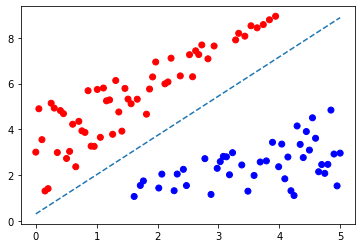

In [176]:
plt.scatter(x, y1, c=['red' if y == 1 else 'blue' for y in yb])
plt.plot(x, -x * p.weights[0]/p.weights[1] - p.bias/p.weights[1], '--')

In [177]:
def line(p1, p2):
    m = (p1[1] - p2[1])/(p1[0] - p2[0])
    b = p1[1] - p1[0]*m
    return {'m': m, 'b': b}

def line_from_point(point, m):
    return {'m': m, 'b': point[1] - m*point[0]}

def perpendicular_line(p, m, b):
    m_perpendicular = -1/m
    b_perpendicular = p[1] - p[0]*m_perpendicular
    return {'m': m_perpendicular, 'b': b_perpendicular}

def line_intersection(m1, b1, m2, b2):
    if m1 == m2 and b1 != b2:
        return None
    x = (b1 - b2)/(m2 - m1)
    y = m1*x + b1
    return np.array((x,y))

def point_belongs_to_line(p, m, b):
    return p[1] == m*p[0] + b

def distance_to_line(p, m, b):
    return np.linalg.norm(p - line_intersection(m, b, *perpendicular_line(p, m, b).values()))

def distances_to_line(points, m, b):
    def distance_to_particular_line(p):
        return distance_to_line(p, m, b)
    return map(distance_to_particular_line, points)

def director(m, b):
    point1 = np.array([0,b])
    point2 = np.array([1,m+b])
    return (point2-point1)/np.linalg.norm(point2-point1)

def translate_line(m, b, d):
    direction = director(-1/m,b)
    return line_from_point(np.array([0,b]) + d*direction, m)

point1, point2 = np.array([0,0]), np.array([1,1])

In [178]:
line(point1, point2)

{'m': 1.0, 'b': 0.0}

In [179]:
point3 = np.array([1,0])
perpendicular_line(point3, *line(point1, point2).values())

{'m': -1.0, 'b': 1.0}

In [180]:
line_intersection(*line(point1, point2).values(), 
                  *perpendicular_line(point3, *line(point1, point2).values()).values())

array([0.5, 0.5])

In [181]:
point4 = np.array([0,1])
assert distance_to_line(point4, 1, 0) == np.power(2, 0.5)/2

In [182]:
points = [np.array([0,1]), np.array([1,0])]
list(distances_to_line(points, 1, 0))

[0.7071067811865476, 0.7071067811865476]

In [183]:
class1 = np.array(list(filter(lambda data : data[2] == 1, np.column_stack((np.column_stack((x, y1)), yb)))))
class2 = np.array(list(filter(lambda data : data[2] == -1, np.column_stack((np.column_stack((x, y1)), yb)))))

In [184]:
min(distances_to_line(class1[:, :2],*p.get_line().values()))

0.3735248478646016

In [185]:
min(distances_to_line(class2[:, :2],*p.get_line().values()))

0.8007198674388215

In [186]:
best_line = p.get_line()
best_margin = [min(distances_to_line(class1[:, :2],*best_line.values())),
               min(distances_to_line(class2[:, :2],*best_line.values()))]

closest_1 = list(zip(class1[:,:2],distances_to_line(class1[:, :2], *best_line.values())))
closest_1.sort(key=lambda p : p[1])
closest_1 = np.array([p[0] for p in closest_1[:4]])
closest_2 = list(zip(class2[:,:2],distances_to_line(class2[:, :2], *best_line.values())))
closest_2.sort(key=lambda p : p[1])
closest_2 = np.array([p[0] for p in closest_2[:4]])

set_1 = closest_1
set_2 = closest_2

for _ in range(2):
    for points_1 in itertools.combinations(set_1, 2):
        for point_2 in set_2:
            line1 = line(points_1[0], points_1[1])
            line2 = perpendicular_line(point_2, *line1.values())
            point_intersection = line_intersection(*line1.values(), *line2.values())
            candidate_line = line_from_point(0.5*(point_intersection + point_2), line1['m'])
            candidate_margin = [min(distances_to_line(class1[:, :2],*candidate_line.values())),
                    min(distances_to_line(class2[:, :2],*candidate_line.values()))]
            candidate_line = translate_line(*candidate_line.values(),
                                           0.5*(candidate_margin[1] - candidate_margin[0]))
            candidate_margin = [min(distances_to_line(class1[:, :2],*candidate_line.values())),
                    min(distances_to_line(class2[:, :2],*candidate_line.values()))]
            if min(candidate_margin) > min(best_margin):
                best_line = candidate_line
                best_margin = candidate_margin
                best_points1 = points_1
                best_point2 = point2
    set_2 = closest_1
    set_1 = closest_2

In [187]:
best_line

{'m': 2.0328450240582665, 'b': -0.45477077922711784}

In [188]:
best_margin

[0.61158030413163, 0.6115803041316297]

In [189]:
np.array(best_points1)[:, :]

array([[0.15151515, 1.31360323],
       [0.2020202 , 1.41627217]])

In [190]:
best_point2

array([1, 1])

In [191]:
best_margin

[0.61158030413163, 0.6115803041316297]

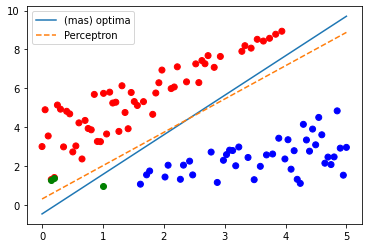

In [192]:
plt.scatter(x, y1, c=['red' if y == 1 else 'blue' for y in yb])
plt.scatter(best_point2[0], best_point2[1], color='green')
plt.scatter(np.array(best_points1)[:,0], np.array(best_points1)[:,1], color='green')
plt.plot(x, x*best_line['m'] + best_line['b'])
plt.plot(x, -x * p.weights[0]/p.weights[1] - p.bias/p.weights[1], '--')
plt.legend(['(mas) optima', 'Perceptron'] )

[0.6469348141397223, 0.6044038246532667]


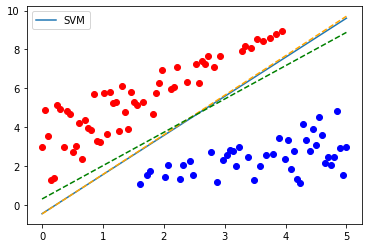

In [193]:
svc = svm.SVC(kernel='linear')
ins = np.row_stack((class1[:, :2], class2[:, :2]))
outs = np.append(class1[:,2], class2[:, 2])
svc.fit(ins, outs)
w = svc.coef_[0]
y_svm = x * (-w[0]/w[1]) - (svc.intercept_[0]/w[1])
plt.scatter(class1[:,0],class1[:,1], color='red')
plt.scatter(class2[:,0],class2[:,1], color='blue')
plt.plot(x, y_svm)
plt.plot(x, x*best_line['m'] + best_line['b'], '--', color='orange')
plt.plot(x, -x * p.weights[0]/p.weights[1] - p.bias/p.weights[1], '--', color='green')
plt.legend(['SVM'])

best_margin = [min(distances_to_line(class1[:, :2],-w[0]/w[1], -svc.intercept_[0]/w[1])),
              min(distances_to_line(class2[:, :2],-w[0]/w[1], -svc.intercept_[0]/w[1]))]
print(best_margin)

In [194]:
contaminated_points = np.column_stack(([2.5, 3.], [x * (-w[0]/w[1]) - (svc.intercept_[0]/w[1]) + 1.5 for x in [2.5, 3.]]))
print(contaminated_points)

[[2.5        6.08274625]
 [3.         7.08804806]]


In [195]:
class2 = np.row_stack((class2, np.column_stack((contaminated_points, [-1, -1]))))

In [196]:
class2[-5:]

array([[ 4.8989899 ,  2.92677793, -1.        ],
       [ 4.94949495,  1.5367581 , -1.        ],
       [ 5.        ,  2.96653317, -1.        ],
       [ 2.5       ,  6.08274625, -1.        ],
       [ 3.        ,  7.08804806, -1.        ]])

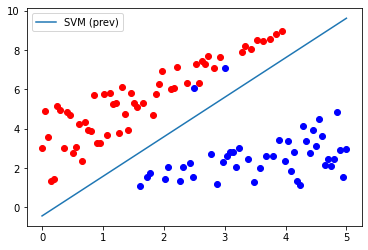

In [197]:
plt.scatter(class1[:,0],class1[:,1], color='red')
plt.scatter(class2[:,0],class2[:,1], color='blue')
plt.plot(x, y_svm)
plt.legend(['SVM (prev)'])

[0.35817320654593865, 0.6255742204775889]

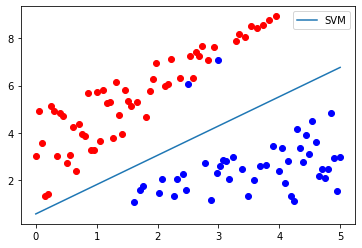

In [208]:
svc = svm.SVC(kernel='linear', C=1000000)
ins = np.row_stack((class1[:, :2], class2[:, :2]))
outs = np.append(class1[:,2], class2[:, 2])
svc.fit(ins, outs)
w = svc.coef_[0]
y_svm = x * (-w[0]/w[1]) - (svc.intercept_[0]/w[1])
plt.scatter(class1[:,0],class1[:,1], color='red')
plt.scatter(class2[:,0],class2[:,1], color='blue')
plt.plot(x, y_svm)
plt.legend(['SVM'])
best_margin = [min(distances_to_line(class1[:, :2],-w[0]/w[1], -svc.intercept_[0]/w[1])),
              min(distances_to_line(class2[:, :2],-w[0]/w[1], -svc.intercept_[0]/w[1]))]
best_margin

In [205]:
p = Perceptron(2)
p.set_training_set(np.row_stack((class1[:,:2], class2[:,:2])), np.append(class1[:,2], class2[:,2]))
p.train_incremental(0.1, 1000)

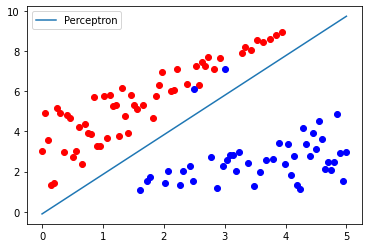

In [206]:
plt.scatter(class1[:,0],class1[:,1], color='red')
plt.scatter(class2[:,0],class2[:,1], color='blue')
plt.plot(x, x*p.get_line()['m'] + p.get_line()['b'])
plt.legend(['Perceptron'])